In [1]:
%load_ext autoreload
%autoreload 2

# 自己瞎折腾的部分

In [ ]:
def get_mapping_relation_pincushion(height, width, a=0.0, b=0, c=-0.2, d=1.0):
    """
    Args:
        image(np.array, [H, W, 3]): original image
        a(float): affects only the outermost pixels of the image(x^4)
        b(float): most cases only require b optimization(x^3)
        c(float): most uniform correction(x^2)
        d(float): describes the linear scaling of the image(x)
    Returns:
        location_of_dest_image(np.array): destination of the original image index
    """
    x, y = np.meshgrid(range(width), range(height))
    x = x.reshape(-1)
    y = y.reshape(-1)
    location_of_source_image = np.stack([x, y], 1)

    center_x = x.mean()
    center_y = y.mean()
    center = np.array([center_x, center_y])
    norm = np.linalg.norm(center)
    dist = np.sqrt(((location_of_source_image - center) ** 2).sum(1))
    r = np.sqrt(((x - center_x) / norm) ** 2 + ((y - center_y) / norm) ** 2) # r=dist/norm, r in [0, 1]
    rdest = (a * r ** 4 + b * r ** 3 + c * r ** 2 + d * r) * norm
    target_x = rdest / dist * (x - center_x) + center_x
    target_y = rdest / dist * (y - center_y) + center_y
    location_of_dest_image = np.stack([target_x, target_y], 1)
    return location_of_dest_image.reshape((-1, 2))

def get_mapping_relation_barrel(height, width, a=0.0, b=0, c=-0.2, d=1.0):
    x, y = np.meshgrid(range(width), range(height))
    x = x.reshape(-1)
    y = y.reshape(-1)
    location_of_source_image = np.stack([x, y], 1)

    center_x = x.mean()
    center_y = y.mean()
    center = np.array([center_x, center_y])
    norm = np.linalg.norm(center)
    r = np.sqrt(((x - center_x) / norm) ** 2 + ((y - center_y) / norm) ** 2)
    ratio = 1/(c*r**2 + d) # this is the key difference
    target_x = ratio * (x - center_x) + center_x
    target_y = ratio * (y - center_y) + center_y
    location_of_dest_image = np.stack([target_x, target_y], 1)
    return location_of_dest_image.reshape((-1, 2))



def map_image(image, map_array):
    height, width = image.shape[:2]
    map_x = map_array[:, 1].reshape((height, width)).astype(np.float32)
    map_y = map_array[:, 0].reshape((height, width)).astype(np.float32)
    mapped_img = cv2.remap(image, map_y, map_x, cv2.INTER_LINEAR)
    return mapped_img


# NOTE, this map_xy is return xy and get_mapping_relation is return yx
def map_xy(x, y, x_c=639.5, y_c=359.5, c=-0.2, d=1):
    """
    ratio: 比例 > 1就是桶形畸变，< 1 就是枕形畸变 ！！！这个不对，要看直线变换后变成什么样了才知道，而不是一个点
    Formulation:
        xm = ratio*(x-x_c) + x_c
        ym = ratio*(y-y_c) + y_c
        很容易理解，就是把x_c和y_c当成新的坐标系零点, 此时[x - x_c, y - y_c]就是一个向量
        我们乘以这个向量<1的ratio，则缩小(朝着零点方向), 就是枕形畸变
        我们乘以这个向量>1的ratio，则放大(远离零点方向), 就是桶形畸变
    
    所以我们一般设置d=1, 由c来控制正负。这样c*dist_relative就表示了到底是往哪边偏,
        c > 0的情况下就是往外(桶形)
        c < 0的情况下就是往里(枕形)
    
    """
    norm = np.linalg.norm((x_c, y_c))
    x_norm = (x - x_c)/norm
    y_norm = (y- y_c)/norm
    dist_relative = np.sqrt(x_norm**2 + y_norm**2)
    dist_map_relative = c*dist_relative**2 + d*dist_relative
    ratio = dist_map_relative/dist_relative # this is c*dist_relative + d
    xm = ratio*(x-x_c) + x_c
    ym = ratio*(y-y_c) + y_c
    return xm, ym

def map_xy_pin(x, y, x_c=639.5, y_c=359.5, c=-0.2, d=1):
    """
    ratio: 比例 > 1就是桶形畸变，< 1 就是枕形畸变 ！！！这个不对，要看直线变换后变成什么样了才知道，而不是一个点
    Formulation:
        xm = ratio*(x-x_c) + x_c
        ym = ratio*(y-y_c) + y_c
        很容易理解，就是把x_c和y_c当成新的坐标系零点, 此时[x - x_c, y - y_c]就是一个向量
        我们乘以这个向量<1的ratio，则缩小(朝着零点方向), 就是枕形畸变
        我们乘以这个向量>1的ratio，则放大(远离零点方向), 就是桶形畸变
    
    所以我们一般设置d=1, 由c来控制正负。这样c*dist_relative就表示了到底是往哪边偏,
        c > 0的情况下就是往外(桶形)
        c < 0的情况下就是往里(枕形)
    
    """
    norm = np.linalg.norm((x_c, y_c))
    x_norm = (x - x_c)/norm
    y_norm = (y- y_c)/norm
    dist_relative = np.sqrt(x_norm**2 + y_norm**2)
    dist_map_relative = c*dist_relative**2 + d*dist_relative
    ratio = dist_map_relative/dist_relative # this is c*dist_relative + d
    xm = ratio*(x-x_c) + x_c
    ym = ratio*(y-y_c) + y_c
    return xm, ym

# NOTE, this map_xy is return xy and get_mapping_relation is return yx
def map_xy_barrel(x, y, x_c=639.5, y_c=359.5, c=-0.2, d=1):
    """
    ratio: 比例 > 1就是桶形畸变，< 1 就是枕形畸变 ！！！这个不对，要看直线变换后变成什么样了才知道，而不是一个点
    Formulation:
        xm = ratio*(x-x_c) + x_c
        ym = ratio*(y-y_c) + y_c
        很容易理解，就是把x_c和y_c当成新的坐标系零点, 此时[x - x_c, y - y_c]就是一个向量
        我们乘以这个向量<1的ratio，则缩小(朝着零点方向), 就是枕形畸变
        我们乘以这个向量>1的ratio，则放大(远离零点方向), 就是桶形畸变
    
    所以我们一般设置d=1, 由c来控制正负。这样c*dist_relative就表示了到底是往哪边偏,
        c > 0的情况下就是往外(桶形)
        c < 0的情况下就是往里(枕形)
    
    """
    norm = np.linalg.norm((x_c, y_c))
    x_norm = (x - x_c)/norm
    y_norm = (y- y_c)/norm
    dist_relative = np.sqrt(x_norm**2 + y_norm**2)
    dist_map_relative = c*dist_relative**3 + d*dist_relative
    ratio = dist_relative/dist_map_relative # this is c*dist_relative + d
    xm = ratio*(x-x_c) + x_c
    ym = ratio*(y-y_c) + y_c
    return xm, ym

# barrel

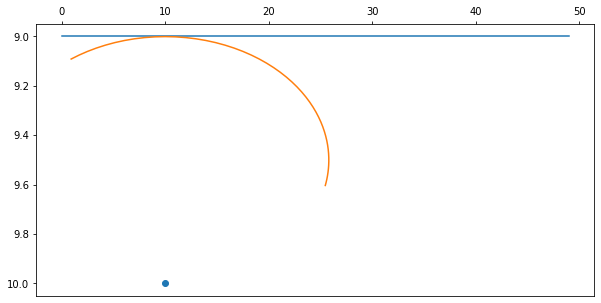

In [32]:
xs = list(range(50))
ys = [9]*len(xs)
out_xs = []
out_ys = []
for x in xs:
    out_x, out_y = map_xy_barrel(x, 9, 10, 10, 0.2, 1)
    out_xs.append(out_x)
    out_ys.append(out_y)
fig, axs = plt.subplots(1, 1, figsize=(10, 5))

plt.plot(xs, ys)
plt.plot(out_xs, out_ys)
# plt.scatter(0, 0)
plt.scatter(10, 10)

axs.set_ylim(axs.get_ylim()[::-1])# invert the axis     
axs.xaxis.tick_top()             # and move the X-Axis    

# pincushion

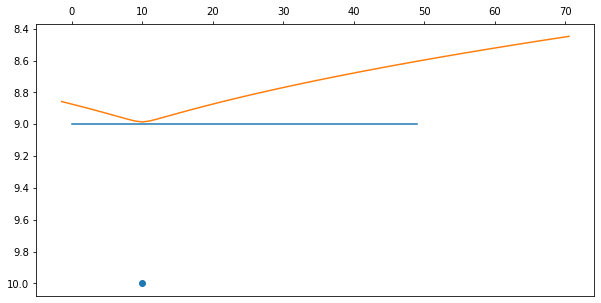

In [19]:
xs = list(range(50))
ys = [9]*len(xs)
out_xs = []
out_ys = []
for x in xs:
    out_x, out_y = map_xy(x, 9, 10, 10, 0.2, 1)
    out_xs.append(out_x)
    out_ys.append(out_y)
fig, axs = plt.subplots(1, 1, figsize=(10, 5))

plt.plot(xs, ys)
plt.plot(out_xs, out_ys)
# plt.scatter(0, 0)
plt.scatter(10, 10)

axs.set_ylim(axs.get_ylim()[::-1])# invert the axis     
axs.xaxis.tick_top()             # and move the X-Axis    

# 解读
get_mapping_relation的点[0,0]的数值表示在畸变后的图里这个点出现的位置, 所以在畸变后的图里去找这个点的数值就是这个点的数值，但是往往这个点并不是整数，所以需要进行插值：
$$
dst(x,y) = src(map\_xy(x,y))
$$
where src is distort image, dst is the desire image.
map_xy是get_mapping_relation的单点版本。
我们可以写出$(map\_xy)^{-1}$:  
```
x = g(xm, ym)...  
y = h(ym, ym)... 
set:
xm = e
ym = f
xc = g
yc = h
y/x = ym/xm # since they are on the same line
solve (f-h)/(y-h) = d + c sqrt(((y e - g f)/nf)^2 + ((y - g)/n)^2) in wolfram alpha gives CRAZY long result , mayby I am wrong
```

In [1]:
x, y = np.meshgrid(range(10), range(10))

# 开始严谨(paper)

1. Review of geometric distortion compensation in fish-eye cameras

- polynomial model:
    $$
    \frac{x_u}{x_d} = \frac{r_u}{r_d} \\
    \implies x_d = x_u\frac{r_d}{r_u}\\
    \implies x_d = L(r)x_u,\quad L(r) = \frac{r_d}{r_u}\\
    \text{Do the same for y:   }y_d = L(r)y_u \\
    \implies {x_d \choose y_d} = L(r){x_u \choose y_u}\\
    \text{In the paper: } r_d = r_u + k_1r_u^3 + \cdots + k_nr_u^{2n+1} \\
    \implies L(r) = \frac{r_d}{r_u} = 1 + k_1r_u^2 + \cdots + k_nr_u^{2n}
    $$
which coincides with [An Iterative Optimization Algorithm for Lens Distortion
Correction Using Two-Parameter Models](http://www.ipol.im/pub/art/2016/130/article.pdf)

-division model:
   $$
    \frac{x_u}{x_d} = \frac{r_u}{r_d} \\
    \implies x_u = x_d\frac{r_u}{r_d}\\
    \implies x_u = L(r)x_d,\quad L(r) = \frac{r_u}{r_d}\\
    \text{Do the same for y:   }y_u = L(r)y_d \\
    \implies {x_u \choose y_u} = L(r){x_d \choose y_d}\\
    \text{In the paper: } r_u = \frac{r_d}{1 + k_1r_d^2 + \cdots + k_nr_d^{2n}} \\
    \implies L(r) = \frac{r_u}{r_d} = \frac{1}{1 + k_1r_d^2 + \cdots + k_nr_d^{2n}}
    $$
which also coincides with [An Iterative Optimization Algorithm for Lens Distortion
Correction Using Two-Parameter Models](http://www.ipol.im/pub/art/2016/130/article.pdf)

# 